In [30]:
import tensorflow as tf 
import numpy as np 
from tensorflow import keras 
import os 
import math 
import random 
import pickle 
import glob
import matplotlib.pyplot as plt 
from collections import deque 
from tensorflow.keras import layers
import time 
import scipy.io as sio

from vehicle_model_variant import Environment_DDPG 
from vehicle_model_ECMS import Environment_ECMS  
from cell_model import CellModel 
from driver_MDP import Driver_MDP 

os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [31]:
battery_path = "../../OC_SIM_DB/OC_SIM_DB_Bat/OC_SIM_DB_Bat_nimh_6_240_panasonic_MY01_Prius.mat"
motor_path = "../../OC_SIM_DB/OC_SIM_DB_Mot/OC_SIM_DB_Mot_pm_95_145_X2.mat"
cell_model = CellModel()
driver = Driver_MDP(0.02) 

num_states = 4 

In [3]:
def get_best_EF(env, EF_temp, threshold): 
    while True: 
        print(EF_temp)
        history = env.PMP_calculation(EF_temp)

        SOC_final = history["SOC_traj"][-1]
        fuel_consumption = np.sum(history["fc_traj"])
        print("Equivalent factor: {:.2f}, Final SOC: {:.4f}, fuel_consumption: {:.4f}".
              format(EF_temp, SOC_final, fuel_consumption))

        if abs(SOC_final - 0.6) < threshold: 
            break 

        EF_temp += 5 * (SOC_final - 0.6)

    return EF_temp 

In [32]:
driving_cycle_path = '../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat'
driving_cycle = sio.loadmat(driving_cycle_path)
driving_cycle = driving_cycle["sch_cycle"][:, 1]
env = Environment_ECMS(cell_model, driving_cycle, battery_path, motor_path)

EF = get_best_EF(env, -30, 0.01)

-30
SOC is too low..
Equivalent factor: -30.00, Final SOC: 0.0047, fuel_consumption: 0.0111
-32.97636568551927
SOC is too low..
Equivalent factor: -32.98, Final SOC: 0.0047, fuel_consumption: 0.0111
-35.95273137103854
SOC is too low..
Equivalent factor: -35.95, Final SOC: 0.0047, fuel_consumption: 0.0111
-38.92909705655781
SOC is too low..
Equivalent factor: -38.93, Final SOC: 0.0047, fuel_consumption: 0.0111
-41.90546274207708
SOC is too low..
Equivalent factor: -41.91, Final SOC: 0.0041, fuel_consumption: 0.1761
-44.88506180915487
SOC is too low..
Equivalent factor: -44.89, Final SOC: 0.0047, fuel_consumption: 0.4515
-47.861523521193035
SOC is too low..
Equivalent factor: -47.86, Final SOC: 0.0048, fuel_consumption: 0.8365
-50.83749942974473
SOC is too low..
Equivalent factor: -50.84, Final SOC: 0.0049, fuel_consumption: 2.5977
-53.81308422015433
Equivalent factor: -53.81, Final SOC: 0.0412, fuel_consumption: 4.8530
-56.60722393947787
Equivalent factor: -56.61, Final SOC: 0.0878, fue

In [33]:
def get_actor(): 
    last_init = tf.random_uniform_initializer(minval=-0.003, maxval=0.003)
    
    inputs = layers.Input(shape=(num_states))
    inputs_batchnorm = layers.BatchNormalization()(inputs)
    
    out = layers.Dense(512, activation="relu")(inputs_batchnorm)
#     out = layers.BatchNormalization()(out)
    out = layers.Dense(512, activation="relu")(out)
#     out = layers.BatchNormalization()(out)
    outputs = layers.Dense(1, activation="sigmoid", 
                          kernel_initializer=last_init)(out)
    model = tf.keras.Model(inputs, outputs)
    return model

def get_critic(): 
    state_input = layers.Input(shape=(num_states))
    state_input_batchnorm = layers.BatchNormalization()(state_input)
    
    state_out = layers.Dense(16, activation="relu")(state_input_batchnorm)
#     state_out = layers.BatchNormalization()(state_out)
    state_out = layers.Dense(32, activation="relu")(state_out)
#     state_out = layers.BatchNormalization()(state_out)
    
    action_input = layers.Input(shape=(1))
    action_out = layers.Dense(32, activation="relu")(action_input)
#     action_out = layers.BatchNormalization()(action_out)
    
    concat = layers.Concatenate()([state_out, action_out]) 
    
    out = layers.Dense(512, activation="relu")(concat)
#     out = layers.BatchNormalization()(out)
    out = layers.Dense(512, activation="relu")(out)
#     out = layers.BatchNormalization()(out)
    outputs = layers.Dense(1)(out)
    
    model = tf.keras.Model([state_input, action_input], outputs)
    return model 
    
    
actor_model = get_actor() 

In [34]:
def policy_epsilon_greedy(state, eps): 
    j_min = state[0][-2].numpy()
    j_max = state[0][-1].numpy()

    if random.random() < eps: 
        a = random.randint(0, 9)
        return np.linspace(j_min, j_max, 10)[a]
    else: 
        sampled_action = tf.squeeze(actor_model(state)).numpy()  
        legal_action = sampled_action * j_max 
        legal_action = np.clip(legal_action, j_min, j_max)
        return legal_action

In [35]:
def test_model(cycle, model_path, EF, fig_title): 
#     test_cycle = driver.get_cycle() 
    env_ECMS = Environment_ECMS(cell_model, cycle, battery_path, motor_path)
    history_ECMS = env_ECMS.PMP_calculation(EF)
#     print(history_ECMS)
    
    env_DDPG = Environment_DDPG(cell_model, cycle, battery_path, motor_path, 10) 
    actor_model.load_weights(model_path)
    
    total_reward = 0 
    state = env_DDPG.reset() 
    while True: 
        tf_state = tf.expand_dims(tf.convert_to_tensor(state), 0)
        action = policy_epsilon_greedy(tf_state, -1)
        next_state, reward, done = env_DDPG.step(action)
        
        state = next_state 
        total_reward += reward 
        
        if done: 
            break 
        
#     SOC_deviation_history = np.sum(np.abs(np.array(env.history["SOC"]) - 0.6)) 
    history_DDPG = env_DDPG.history 
    print("******************* Test is start *****************")
#     print(test_cycle)
#     print(history_ECMS["SOC_traj"][-1])
#     print(env_DDPG.fuel_consumption)
    print("final SOC for ECMS: {:.4f}, final SOC for DDPG: {:.4f}".format(
        history_ECMS["SOC_traj"][-1], history_DDPG["SOC"][-1]))
    print("FC for ECMS: {:.4f}, FC for DDPG: {:.4f}".format(np.sum(history_ECMS["fc_traj"]), 
                                                            env_DDPG.fuel_consumption))
    print("******************* Test is done *****************")
    print("")
    
    
    
    plt.figure(figsize=(10, 14))
    
    plt.subplot(2, 1, 1)
    plt.plot(cycle * 3.6, linewidth=2, )
    plt.ylabel("Velocity[km/h]", fontsize=16)
    plt.grid() 
    
    plt.subplot(2, 1, 2)
    plt.plot(history_ECMS["SOC_traj"], linewidth=2, label="SOC trajectory for ECMS") 
    plt.plot(history_DDPG["SOC"], linewidth=2, label="SOC trajectory for DDPG")
    
    plt.grid() 
    plt.xlabel("Time[s]", fontsize=16)
    plt.ylabel("SOC", fontsize=16)
    plt.legend(fontsize=18)
    plt.savefig("{}.png".format(fig_title))
    return history_DDPG 

maximum steps, simulation is done ... 
******************* Test is start *****************
final SOC for ECMS: 0.4612, final SOC for DDPG: 0.6061
FC for ECMS: 43.4987, FC for DDPG: 55.8101
******************* Test is done *****************



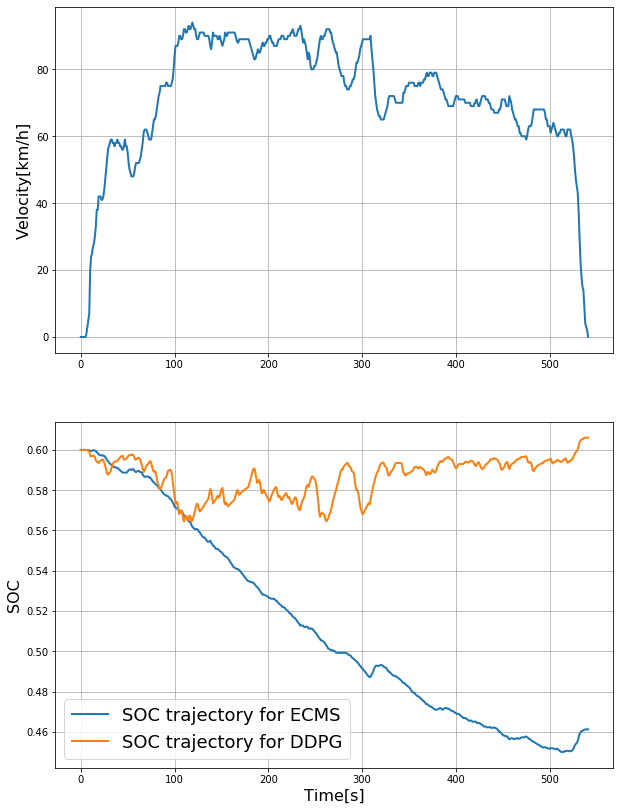

In [40]:
training_cycle = '../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat'

test_cycles = [
    "../data/driving_cycles/all/00_nedc.mat", 
    "../data/driving_cycles/all/cudec_freeway.mat",
] 
# driving_cycle = sio.loadmat(training_cycle)
driving_cycle = sio.loadmat(test_cycles[1])
driving_cycle = driving_cycle["sch_cycle"][:, 1]


# actor = "./DDPG_reference_trained_variant_all/actor_model.h5" 
actor = "./DDPG_MDP_trained/actor_model.h5" 
history = test_model(driving_cycle, actor, -66.44, "comparison_on_cudec")